In [93]:
import numpy as np 
from PIL import Image, ImageDraw, ImageFont 
from skimage import transform as tf

In [94]:
def create_captcha(text, shear=0, size=(100, 30), scale=1):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"bretan/Coval-Black.otf", 22) 
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    image = image / image.max()
    shape = image.shape
    shapex, shapey = (shape[0] * scale, shape[1] * scale)
    image = tf.resize(image, (shapex, shapey))
    return image

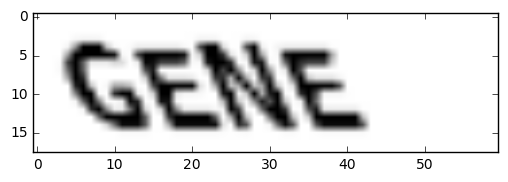

In [95]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5, scale=0.6)
plt.imshow(image, cmap='Greys')

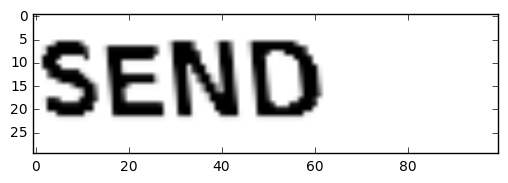

In [96]:
image = create_captcha("SEND", shear=0.1, scale=1.0) 
plt.imshow(image, cmap='Greys')

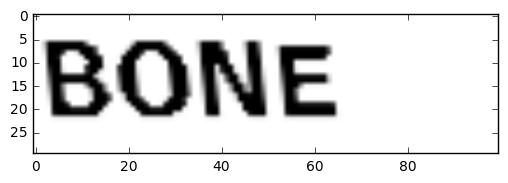

In [97]:
image = create_captcha("BONE", shear=0.1, scale=1.0) 
plt.imshow(image, cmap='Greys')

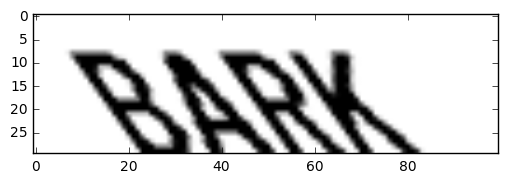

In [98]:
image = create_captcha("BARK", shear=0.8, scale=1.0) 
plt.imshow(image, cmap='Greys')

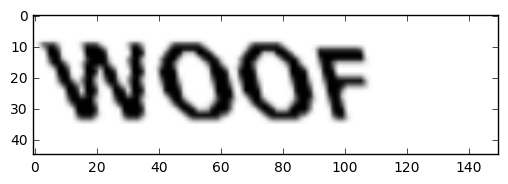

In [99]:
image = create_captcha("WOOF", shear=0.25, scale=1.5)
plt.imshow(image, cmap='Greys')

In [100]:
from skimage.measure import label, regionprops

In [101]:
def segment_image(image):
    # label will find subimages of connected non-black pixels
    labeled_image = label(image>0.2, connectivity=1, background=0)
    subimages = []
    # regionprops splits up the subimages
    for region in regionprops(labeled_image):
        # Extract the subimage
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        # No subimages found, so return the entire image
        return [image,]
    return subimages

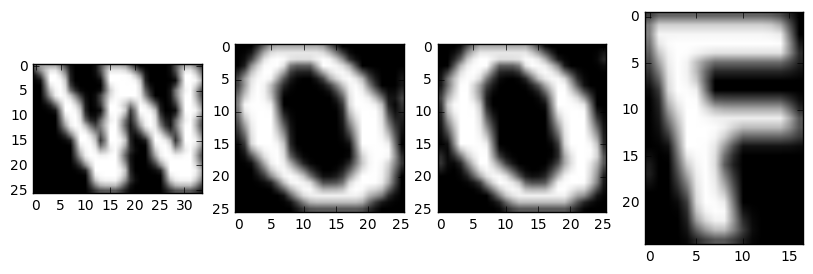

In [102]:
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3)) 
for i in range(len(subimages)): 
    axes[i].imshow(subimages[i], cmap="gray")

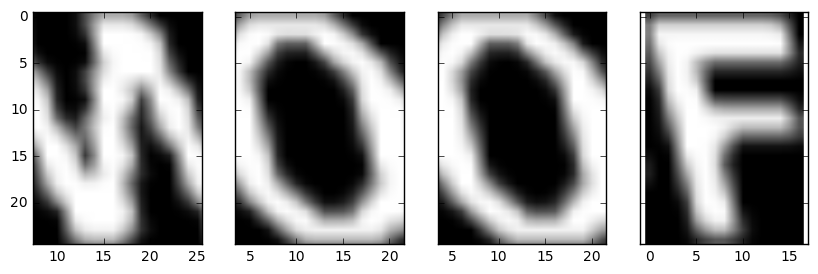

In [103]:
image = create_captcha("WOOF", shear=0.25, scale=1.5)
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3), sharey=True) 
for i in range(len(subimages)): 
    axes[i].imshow(subimages[i], cmap="gray")

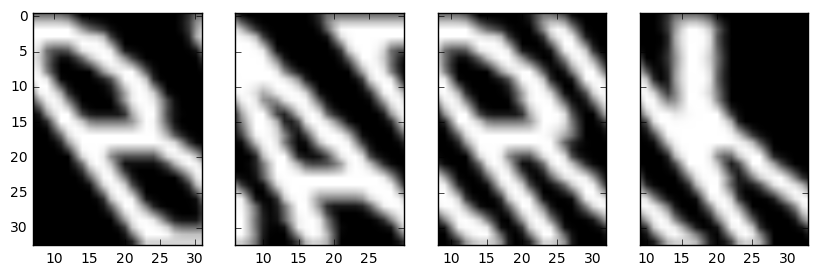

In [104]:
image = create_captcha("BARK", shear=0.8, scale=1.5)
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3), sharey=True) 
for i in range(len(subimages)): 
    axes[i].imshow(subimages[i], cmap="gray")

In [105]:
from sklearn.utils import check_random_state
random_state = check_random_state(14) 
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
assert len(letters) == 26
shear_values = np.arange(0, 0.8, 0.05)
scale_values = np.arange(0.9, 1.1, 0.1)

In [106]:
def generate_sample(random_state=None): 
    random_state = check_random_state(random_state) 
    letter = random_state.choice(letters) 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    return create_captcha(letter, shear=shear, size=(30, 30), scale=scale), letters.index(letter)

The target for this image is: L


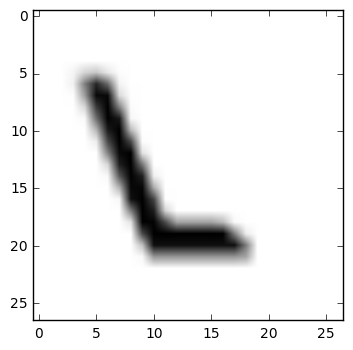

In [107]:
image, target = generate_sample(random_state) 
plt.imshow(image, cmap="Greys") 
print("The target for this image is: {0}".format(letters[target]))

In [108]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(1000)))
dataset = np.array([tf.resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
dataset = np.array(dataset, dtype='float') 
targets = np.array(targets)

In [109]:
from sklearn.preprocessing import OneHotEncoder 
onehot = OneHotEncoder() 
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [110]:
y = y.todense()
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [111]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

E:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [112]:
from sklearn.neural_network import MLPClassifier

In [113]:
clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=14)

In [114]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 14,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [115]:
clf.fit(X_train, y_train)

E:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=14, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [116]:
clf.fit(X_train, y_train)

E:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=14, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [117]:
y_pred = clf.predict(X_test)

In [118]:
from sklearn.metrics import f1_score 
f1_score(y_pred=y_pred, y_true=y_test, average='macro')


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.9461538461538462

In [119]:
from sklearn.metrics import classification_report 
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         1
          17       1.00    

E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [120]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    dataset = np.array([tf.resize(subimage, (20, 20)) for subimage in subimages])
    X_test = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

    y_pred = neural_network.predict_proba(X_test)
    predictions = np.argmax(y_pred, axis=1)
    assert len(y_pred) == len(X_test)
    predicted_word = str.join("", [letters[prediction] for prediction in predictions])
    return predicted_word

GNEE


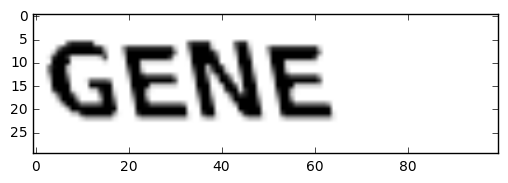

In [121]:
word = "GENE" 
captcha = create_captcha(word, shear=0.2) 
print(predict_captcha(captcha, clf))
plt.imshow(captcha, cmap="Greys")

In [122]:
def test_prediction(word, net, shear=0.2, scale=1):
    captcha = create_captcha(word, shear=shear, scale=scale, size=(len(word) * 25, 30))
    prediction = predict_captcha(captcha, net)
    return word == prediction, word, prediction

In [123]:
from nltk.corpus import words

In [124]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\abhijit\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [125]:
valid_words  =  set([word.upper() for word in words.words() if len(word) == 4])


In [126]:
num_correct = 0 
num_incorrect = 0 
for word in valid_words: 
    shear = random_state.choice(shear_values)
    scale = random_state.choice(scale_values)
    correct, word, prediction = test_prediction(word, clf, shear=shear, scale=scale)
    #print(correct, word, prediction)
    if correct: 
        num_correct += 1 
    else: 
        num_incorrect += 1
        #if len(prediction) == len(word):
        #    print(word, prediction)
print("Number correct is {0}".format(num_correct)) 
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 2158
Number incorrect is 2837


In [127]:
def evaluation_versus_shear(shear_value):
    print(shear_value)
    num_correct = 0 
    num_incorrect = 0 
    for word in valid_words: 
        scale = random_state.choice(scale_values)
        correct, word, prediction = test_prediction(word, clf, shear=shear_value, scale=scale)
        #print(correct, word, prediction)
        if correct: 
            num_correct += 1 
        else: 
            num_incorrect += 1
    return num_correct/(num_correct+num_incorrect)


In [128]:
scores = [evaluation_versus_shear(shear) for shear in shear_values]

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75


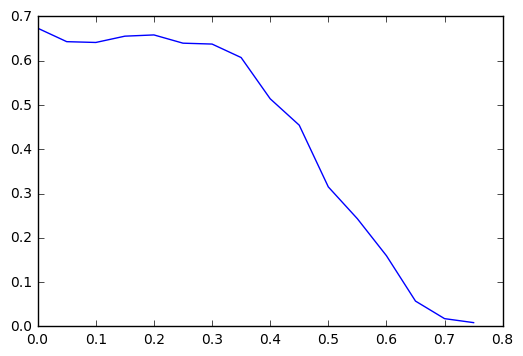

In [129]:
plt.plot(shear_values, scores)

In [130]:
from nltk.metrics import edit_distance 
steps = edit_distance("STEP", "STOP") 
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 1


In [131]:
def compute_distance(prediction, word):
    
    len_word = min(len(prediction), len(word))
    
    return len_word - sum([prediction[i] == word[i] for i in range(len_word)])

In [132]:
from operator import itemgetter 

def improved_prediction(word, net, dictionary, shear=0.2, scale=1.0): 
    captcha = create_captcha(word, shear=shear, scale=scale) 
    prediction = predict_captcha(captcha, net) 
    
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word)) for word in dictionary], key=itemgetter(1))
        best_word = distances[0] 
        prediction = best_word[0]
    return word == prediction, word, prediction

In [133]:
num_correct = 0  
num_incorrect = 0 
for word in valid_words:
    shear = random_state.choice(shear_values) 
    scale = random_state.choice(scale_values)
    correct, word, prediction = improved_prediction(word, clf, valid_words, shear=shear, scale=scale)
    if correct:
        num_correct += 1 
    else: num_incorrect += 1
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 2377
Number incorrect is 2618
